#Implementation of Paper
##Radford, Alec, Luke Metz, and Soumith Chintala. 
##"Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

###DCGAN is a Generative Adversarial Network (GAN) using CNN. The generator tries to fool the discriminator by generating fake images. The discriminator learns to discriminate real from fake images. The generator + discriminator form an adversarial network. DCGAN trains the discriminator and adversarial networks alternately. During training, not only the discriminator learns to distinguish real from fake images, it also coaches the generator part of the adversarial on how to improve its ability to generate fake images.

###Importing Libraries, Modules and Packages

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

###Importing Dataset MNIST Dataset

In [ ]:
from tensorflow.keras.datasets import mnist

###Building Generator for DCGAN

The Model Architecture of DCGAN Generator is given below. This model was used in Original Paper but we have Implemented a Slightly Different Model

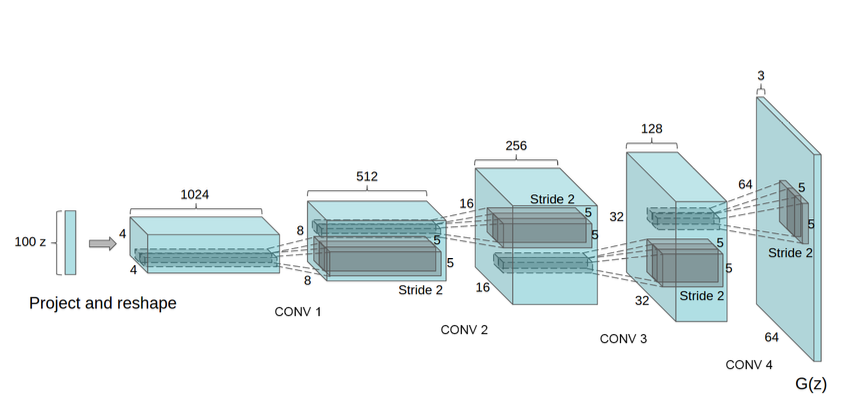

Working of DCGAN is given below

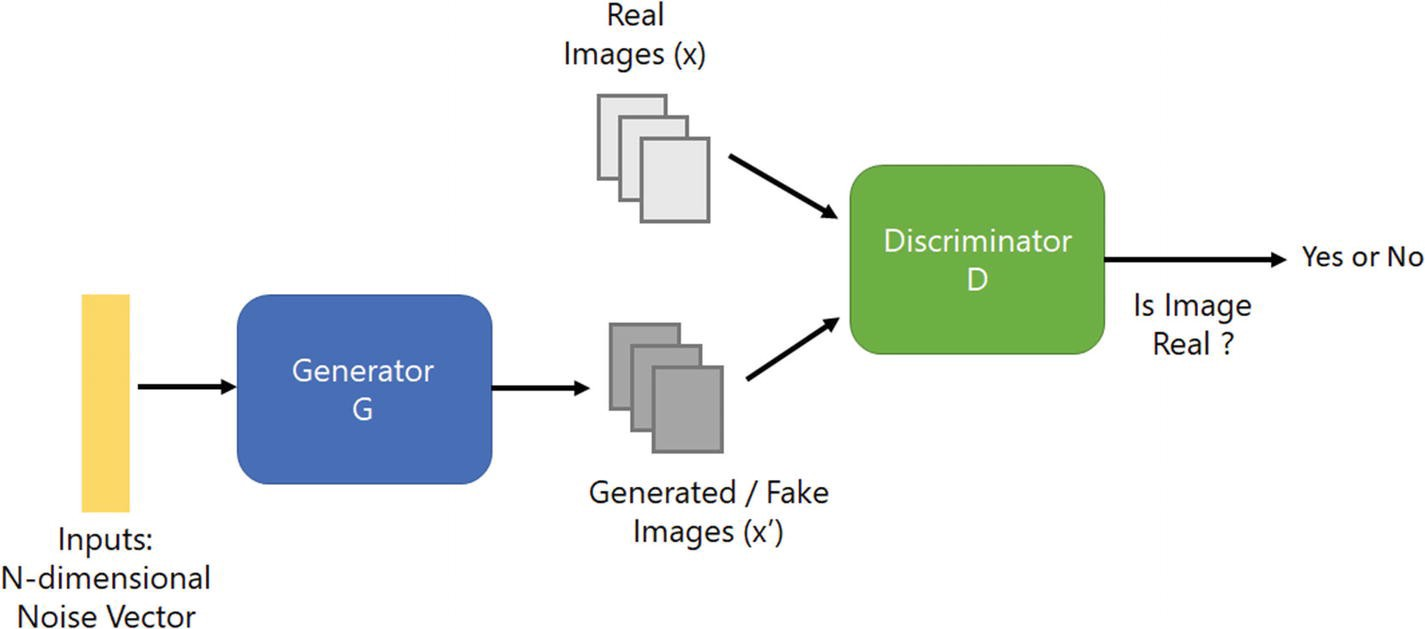

Convolutional Transpose -
1. These are used for upsampling.
2. These are used as Decomposer in Encoder-Decoder models
3. Reconstructs the Spatial Resolution before and performs a convolution

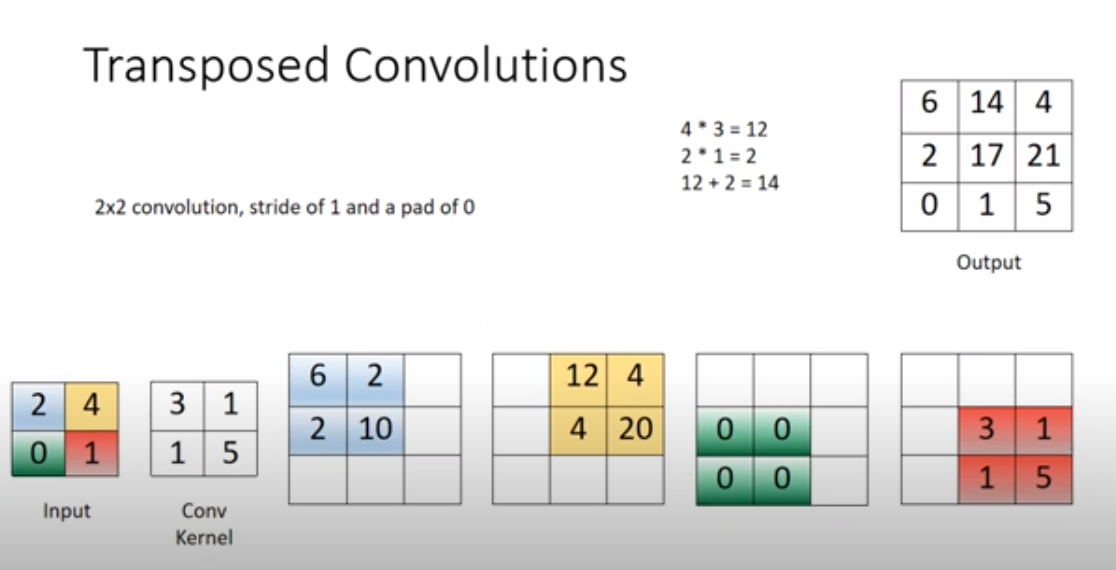

In [ ]:
"""
Build a Generator Model
Stack of BN-ReLU-Conv2DTranpose to generate fake images Output activation is Sigmoid. 

    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        image_size (tensor): Target size of one side (assuming square image)

    Returns:
        generator (Model): Generator Model
"""

def build_generator(inputs, image_size):

    image_resize = image_size // 4

    # network parameters 
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    # As we can observe by above figure that first of all we have to project and reshape the input 
    # Passing the Noise vector to the first layer i.e. Dense Layer having number of nodes = 7*7*128
    x = Dense(image_resize * image_resize * layer_filters[0])(inputs)

    # Output of first layer will be (7*7*128, 1) Now this will be Reshaped to (7,7,128) this will be now fed into CONV blocks 
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1

        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    # Applying Activation Fucntion for the Output
    # This will give us the Probability Map
    x = Activation('sigmoid')(x)

    # Now we will combine Input, Output to the model and name it as "generator"
    generator = Model(inputs, x, name='generator')

    # generator output is the synthesized image x
    return generator

###Building Discriminator for GAN

The Model Architecture of DCGAN Discriminator is given below

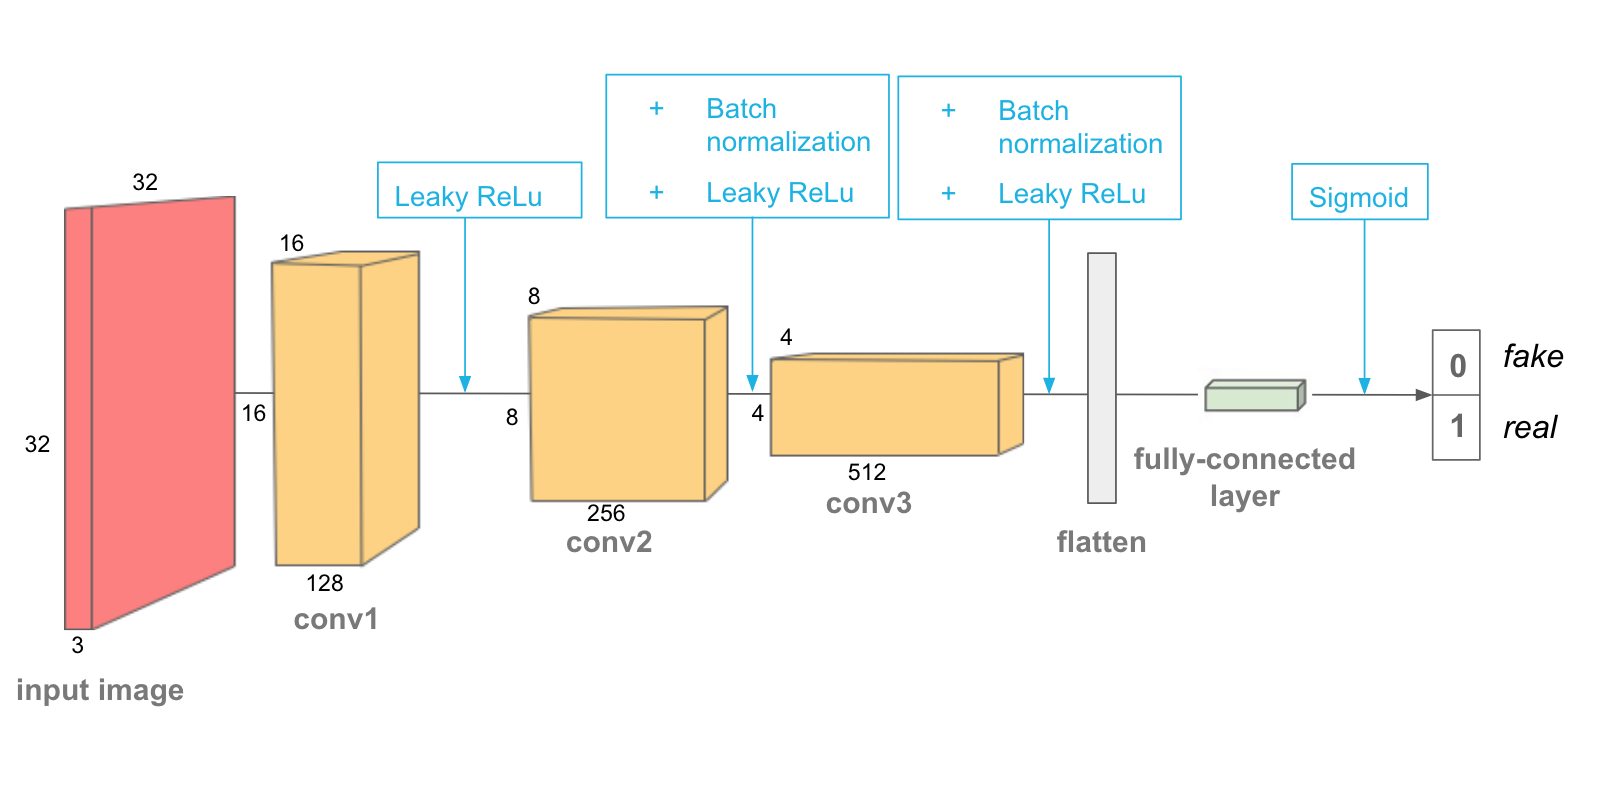

In [ ]:
"""
Build a Discriminator Model
Stack of LeakyReLU-Conv2D to discriminate real from fake.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
    Returns:
        discriminator (Model): Discriminator Model
"""

def build_discriminator(inputs):

    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
            
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

    x = Flatten()(x)

    # default output is probability that the image is real
    x = Dense(1)(x) 

    x = Activation('sigmoid')(x)

    discriminator = Model(inputs, x, name='discriminator')
    
    return discriminator

###Building an Optimizer for GAN

This function is used for Saving Images that are Sampled during the Training Process

In [ ]:
"""
Generate fake images and plot them
For visualization purposes, generate fake images then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

"""

def plot_images(generator, noise_input, images_dir, show=False, step=0, model_name="gan"):

    filename = os.path.join(images_dir, "%05d.png" % step)
    
    # Number of Rows in the sampled images because we will generate 16 images of different Digits for each Step called so rows = 4
    rows = int(math.sqrt(noise_input.shape[0]))

    # Noise input is a collection of 16 different noise vectors
    images = generator.predict(noise_input)
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]

    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

Here we are defining the function for Training process of Generator and Discriminator

####Here the Training Process we follow will be -
####First we will generate images from noise (the number of images will be equal to the batch size) then we will choose random real images of equal number from dataset
####Now we will send these generated fake images alongwith real images to the Discriminator for training purpose that is for differentiating the real images from fake ones.
####Now we will pass another noise vector equal to batch size to the Generator for training purpose of Generator to generate more and more real looking images. Now the generated fake images this time will be labelled as real images and will be passed to the Discriminator
####That is this time Discriminator will get only fake images but all will be labelled as real images in order to fool Discriminator. Now Discriminator will try to classify them as real and fake images.
####Generator wants Discriminator to classify these images more and more real but Discriminator wants to classify these images more and more fake (as these are fake in actual)
####This will act as feedback to Generator.
####These generated fake images during trainig of Generator (Adversarial Network as training of Discriminator is freezed) will not be saved. 

In [ ]:
"""
Train the Discriminator and Adversarial Networks
Alternately train Discriminator and Adversarial networks by batch. Discriminator is trained first with properly real and fake images.
Adversarial is trained next with fake images pretending to be real Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        x_train (tensor): Train images
        params (list) : Networks parameters
        
"""

def train(models, x_train, params, image_dir):

    # the GAN component models
    generator, discriminator, adversarial = models

    # network parameters
    batch_size, latent_size, train_steps, model_name = params

    # the generator image is saved every 500 steps
    save_interval = 500

    # noise vector to see how the generator output evolves during training
    # it is a collection of 16 noise vectors for producing 16 different images
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])

    # number of elements in train dataset
    train_size = x_train.shape[0]

    for i in range(train_steps):

        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]

        # generate fake images from noise using generator 
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])

        # generate fake images
        fake_images = generator.predict(noise)

        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])

        # fake images label is 0.0
        y[batch_size:, :] = 0.0

        # train discriminator network, save the loss and accuracy
        loss, acc = discriminator.train_on_batch(x, y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images with label=1.0 because we are pretending that the images are real
        # since the discriminator weights are frozen in adversarial network only the generator is trained
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0, 1.0,  size=[batch_size, latent_size])

        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])

        # train the adversarial network 
        # note that unlike in discriminator training, we do not save the fake images in a variable
        # the fake images go to the discriminator input of the adversarial for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch(noise, y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)

        if(i % 100 == 0):
            print(log)

        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator, noise_input=noise_input, show=False, step=(i + 1), model_name=model_name, images_dir=image_dir)
   
    # save the model after training the generator the trained generator can be reloaded for future CIFAR photo generation
    generator.save(model_name + ".h5")

###Load the Dataset

In [ ]:
# load MNIST dataset
(x_train, _), (_, _) = mnist.load_data()

# reshape data for CNN as (28, 28, 1) and normalize
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255

model_name = "dcgan_mnist"

###Defining the Hyperparameters

In [ ]:
# network parameters
# the latent or z vector is 100-dim
latent_size = 100
input_shape = (image_size, image_size, 1)
batch_size = 64
lr = 2e-4
decay = 6e-8
train_steps = 40000

In [ ]:
# build DISCRIMINATOR Model
inputs = Input(shape=input_shape, name='discriminator_input')
discriminator = build_discriminator(inputs)

# we are using RMSprop optimizer as discriminator original paper uses Adam, but discriminator converges easily with RMSprop
optimizer = RMSprop(lr=lr, decay=decay)

# compiling the discriminator same as in original paper
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 28, 28, 1)]       0         
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 4, 4, 128)       

In [ ]:
# build GENERATOR Model
input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')

generator = build_generator(inputs, image_size)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_16 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
activation_43 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_28 (Conv2DT (None, 14, 14, 128)       409728    
_________________________________________________________________
batch_normalization_29 (Batc (None, 14, 14, 128)       51

In [ ]:
# build ADVERSARIAL Model = generator + discriminator
optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)

# freeze the weights of discriminator during adversarial training
discriminator.trainable = False

# Here we can see that in the input we passed z-vector as defined in Generator Case and 
# for output we are getting output of Discriminator while input to Discriminator is output to Generator
adversarial = Model(inputs, discriminator(generator(inputs)), name=model_name)

# Compiling Network
adversarial.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
adversarial.summary()

Model: "dcgan_mnist"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_input (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
generator (Functional)       (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator (Functional)   (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 1,300,801
Non-trainable params: 1,081,281
_________________________________________________________________


In [ ]:
# train discriminator and adversarial networks
models = (generator, discriminator, adversarial)
params = (batch_size, latent_size, train_steps, model_name)

# directory where we have to save the sampled images
image_dir = "/content/drive/MyDrive/Colab Notebooks/GAN/DCGAN Implementation/sampled_images"

train(models, x_train, params, image_dir)

0: [discriminator loss: 0.691835, acc: 0.507812] [adversarial loss: 0.911643, acc: 0.000000]
100: [discriminator loss: 0.000014, acc: 1.000000] [adversarial loss: 0.000058, acc: 1.000000]
200: [discriminator loss: 0.000131, acc: 1.000000] [adversarial loss: 0.000119, acc: 1.000000]
300: [discriminator loss: 0.011335, acc: 1.000000] [adversarial loss: 0.002439, acc: 1.000000]
400: [discriminator loss: 0.138639, acc: 0.992188] [adversarial loss: 1.474557, acc: 0.000000]
500: [discriminator loss: 0.316297, acc: 0.781250] [adversarial loss: 6.594935, acc: 0.000000]
600: [discriminator loss: 0.074641, acc: 0.960938] [adversarial loss: 6.471769, acc: 0.000000]
700: [discriminator loss: 0.280324, acc: 0.882812] [adversarial loss: 0.112466, acc: 1.000000]
800: [discriminator loss: 0.605217, acc: 0.664062] [adversarial loss: 1.335530, acc: 0.078125]
900: [discriminator loss: 0.583713, acc: 0.734375] [adversarial loss: 0.972998, acc: 0.218750]
1000: [discriminator loss: 0.545675, acc: 0.695312] 

##For Testing the Model

In [ ]:
test_image_dir = "/content/drive/MyDrive/Colab Notebooks/GAN/DCGAN Implementation/test_sampled_images"
gen_path = "/content/drive/MyDrive/Colab Notebooks/GAN/DCGAN Implementation/dcgan_mnist.h5"

generator = load_model(gen_path, compile=False)

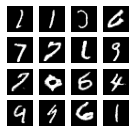

In [ ]:
noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

plot_images(generator, noise_input=noise_input, show=True, model_name="test_outputs", images_dir=test_image_dir)